In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Common problems when dealing with deep neural network

- Gradients growing ever smaller / larger when flowing backwards through the DNN during training. Resulting in lower layers being very hard to train. <br>
    ->

- Not having enough training data for such large network / too costly to label.<br>
    -> Solve through transfer learning and unsupervised pretraining

- Training may be extremely slow.<br>
    -> Solve with various optimizers

- A model with millions of parameteres would severely risk overfitting the training set, especially when there are not enough training instances / too noisy.<br>
    -> Solve with regularization techniques



# Vanishing / Exploding Gradients Problems

Backpropagation works where after computing the error of the output layer, the algorithm will compute the gradients of the cost function with regard to each parameter in the network, and then uses these gradients to update each parameter with a gradient descent step.

--- 
IDEAS FROM STATQUEST: <br>
For an unknown parameter (e.g. bias), use the chain rule to calculate the derivative of the SSR (or cost function) with respect to the unknown parameter. Then initialize the unknown parameter with a number, and use gradient descent to optimize the unknown parameter.

---


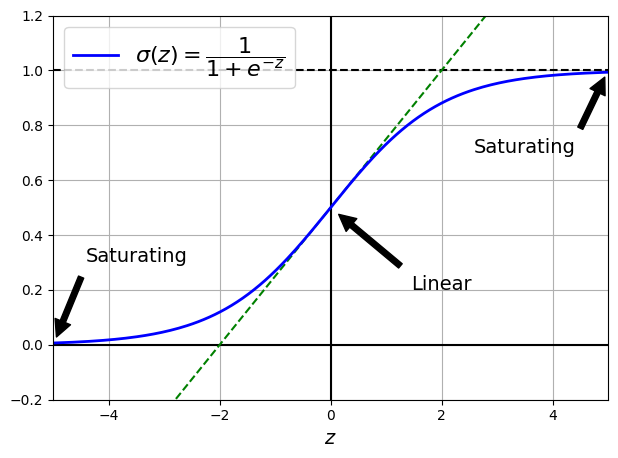

In [7]:
# extra code – this cell generates and saves Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()


*Vanishing Gradients* Problem: <br>
Gradients often get smaller and smaller as the algorithm progresses down to the lower layers, resulting in virtually unchanged weights to the lower layers connections, and training then never converges to a good solution.

*Exploding Gradients* Problem: <br>
Same as above, but the opposite where the gradients grow bigger and bigger. Commonly appear in recurrent neural networks.

This is solved by ensuring that signals flow properly in both directions, forward when making predictions and backwards when backpropagating gradients. Hence, we do this by ensuring that the variance of the output of each layer = variance of its inputs, and that gradients need to have equal variance before and after flowing through a layer in the reverse direction.
This is somewhat achieved by using the the connection weights of 

- $fan_{avg}$ = ($fan_{in} + fan_{out}$) / 2

- Normal distribution with mean 0 and variance $σ^2$ = $1 / fan_{avg}$; OR
Uniform distribution between -r and +r with r = $sqrt(3/fan_{avg})$



Initialization // Activation functions // σ² (Normal) <br>
Glorot // None, tanh, sigmoid, softmax // 1 / $fan_{avg}$ <br>
He // ReLU, Leaky ReLU, ELU, GELU, Swish, Mish // 2 / $fan_{in}$ <br>
LeCun // SELU // 1 / $fan_{in}$ <br>


By default, Keras uses the Glorot initialization with a uniform distribution. It can be switched to He by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"`

In [8]:
import tensorflow as tf

dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

We can also use the `VarianceScaling` initializer. Below is an example of using the He initialization with a uniform distribution and based on $fan_{avg}$ (rather than $fan_{in}$)

In [9]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2.,
                                                    mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Better Activation Functions

Turns out ReLU activation function behaves much better in deep neural networks. But it also suffers from *dying ReLUs*, where during training some neurons effectively "die" (only outputs 0) (in some cases half of the neurons will die if we use a large learning rate). This happens because the input for the ReLU for all instances in the training set is negative, and when this happens the gradient descent = 0, and thus it will never be reactivated. Alternatives can be seen below.

### Leaky ReLU

$LeakyReLU_α(z) = max(αz, z)$

α = how much the function "leaks" / the slope of the function for z < 0. Where a huge leak seem to result in better performance.

Other variants include 
- Randomized Leaky ReLU (RReLU) where α is picked randomly in a given range during training and is fixed to an average value during testing. It performs fairly well and seemed to act as a regularizer and reduces the risk of overfitting the training set. Currently no official implementation in Keras.
- Parametric Leaky ReLU (PReLU), where α is authorized to be learned during training (influenced by backpropagation). This strongly outperforms ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting. To implement this, replace `LeakyReLU` with `PReLU` in the codes below.

All 3 have the weaknes of being **not smooth** functions, which could make the gradient descent bounce around the optimum and slow down convergence!

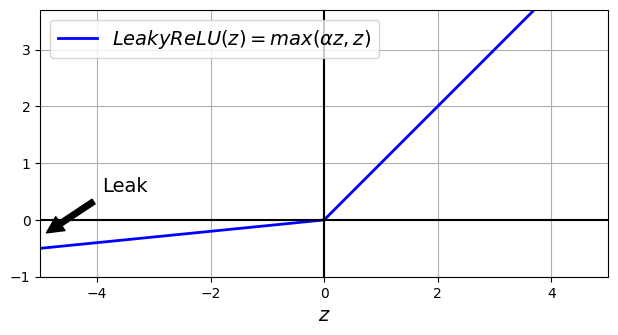

In [10]:
# extra code – this cell generates and saves Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [11]:
# sample leaky relu
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

/Users/kevinkyhalim/ML_repo/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [12]:
# Can also be defined in a separate layer, but this makes
# no difference for training & predictions
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU (Exponential Linear Unit) and SELU (Scaled ELU)

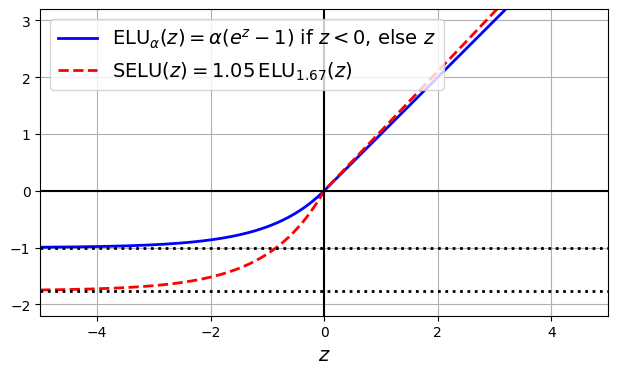

In [13]:
# extra code – this cell generates and saves Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()


ELU activation function<br>
$ELU_α(z)$ =
- α(exp (z) − 1) if z < 0
- z if z ≥ 0

A lot like ReLU with 3 major differences
- Takes on negative value when z < 0, allowing the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem. α defines the opposite of the value that the ELU function approaches when z is a large negative number.
- Has nonzero gradient for z < 0, avoiding the dead neurons problem
- If α = 1, then the function is smooth everywhere, including around z = 0, speeding up the gradient descent!

Drawbacks include:
- Slower to compute compared to ReLU and its variants

In [14]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

For SELU, which is a scaled variance of the ELU. It was shows that for a neural network composed only of a stack of dense layers (i.e. MLP) and if all hidden layers use the SELU activation function, then the network will *self-normalize*: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, solving the vanishing / exploding gradients problem.

However, there are a few conditions for this
- Input features MUST be standardized
- Every hidden layer's weight must be initialized using LeCun normal initialization `kernel_initialization = "lecun_normal"`
- Self-normalizing property is only guaranteed with plain MLPs. It will not work for RNN or networks with *skip connections* (such as the Wide & Deep nets).
- Cannot use regularization techniques like l1 or l2 regularization, max-norm, batch-norm, or regular dropout.

In [15]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

Sample of Self Regularized network using SELU

In [16]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [18]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [19]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Need to scale the inputs to mean 0 and standard deviation 1

In [20]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [21]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4636 - loss: 1.4321 - val_accuracy: 0.7008 - val_loss: 0.8026
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7274 - loss: 0.7400 - val_accuracy: 0.7676 - val_loss: 0.6203
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7773 - loss: 0.6170 - val_accuracy: 0.7894 - val_loss: 0.5741
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8030 - loss: 0.5522 - val_accuracy: 0.8116 - val_loss: 0.5177
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8180 - loss: 0.5078 - val_accuracy: 0.8132 - val_loss: 0.5190


Let's see what happens when we use ReLU instead

In [22]:
tf.random.set_seed(42)

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [24]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [25]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1904 - loss: 2.0531 - val_accuracy: 0.1918 - val_loss: 2.0140
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3478 - loss: 1.6596 - val_accuracy: 0.4722 - val_loss: 1.1951
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5157 - loss: 1.1226 - val_accuracy: 0.6264 - val_loss: 0.9383
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5797 - loss: 1.0394 - val_accuracy: 0.6330 - val_loss: 0.9617
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6832 - loss: 0.8035 - val_accuracy: 0.6592 - val_loss: 0.8694


### GELU, Swish, and Mish

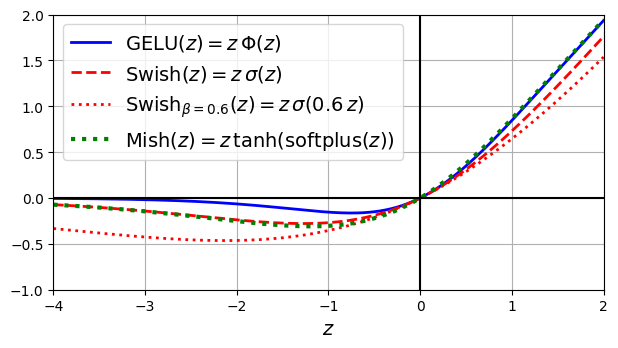

In [26]:
# extra code – this cell generates and saves Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

- GELU -> smooth variance of the ReLU activation function. <br>
$GELU(z)= z Φ(z)$ <br><br>
where Φ is the standard Gaussian CDF, which is the probability that a value sampled randomly from a normal distribution of mean 0 and variance 1 is lower than z. <br> <br>
In practive, it outperforms every other activation function discussed so far, but it is more computationally intensive and the performance boost it provides is not always sufficient to justify the extra cost. <br>
`activation="gelu"`
- Swish / Sigmoid Linear Unit <br>
$Swish_β(z) = zσ(βz)$ <br><br>
GELU is approximately equal to generalized Swish using β = 1.702.  <br>
`activation="swish"`

- Mish <br>
$mish(z) = ztanh(softplus(z))$, <br>
where softplus(z) = log(1 + exp(z)) <br>
In general this outperforms all activation function, and even Swish and GELU (by a tiny margin). <br>
Not supported by Keras, but can be implemented by our own.

In summary:
- Still use **ReLU** as default, as it is often just as good as the more sophisticated activation functions, and very fast to compute, with many libraries and hardware accelerators providing ReLU-specific optimizations.
- For more complex tasks, use **Swish** with learnable β (Mish may give a slightly better result, but requires more time to compute)
- If runtime latency is a factor, use **Leaky ReLU** or **PReLU** for more complex tasks
- For deep MLPs, use **SELU** while respecting the constraints.

## Batch Normalization (BN)

Adding an operation in the model before / after the activation function of each hidden layer to zero-center and normalize each input, then scale and shift the results using 2 new paramater vectors / layer: 1 for scaling, the other for shifting. It is called batch because the algorithm evaluates the mean and standard deviation of the input over the current mini-batch.

Note that training using BN is slow, but is countered by the fact that convergence is faster so it will take fewer epohcs to reach the same performance.

### Implementing batch normalization with Keras

In [27]:
import tensorflow as tf
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28,28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

Notice how there are non-trainable params, which are the μ and σ (moving averages).

In [30]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

In [31]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - accuracy: 0.7508 - loss: 0.7103 - val_accuracy: 0.8530 - val_loss: 0.3993
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 920us/step - accuracy: 0.8560 - loss: 0.4067 - val_accuracy: 0.8680 - val_loss: 0.3651


Applying `BatchNormalization` layer before each activation function. Also since the layer before `BatchNormalization` layer does not need to have bias terms, we can set `use_bias=False` when creating those layers:

In [32]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [34]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.7415 - loss: 0.7956 - val_accuracy: 0.8452 - val_loss: 0.4410
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.8455 - loss: 0.4410 - val_accuracy: 0.8612 - val_loss: 0.4015


## Gradient Clipping

Clipping the gradients during backpropagation so that they never exceed some threshold. Most commonly used in recurrent neural networks, where using batch normalization is tricky.

In [35]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

Use clipnorm to preserve the direction.

In [36]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

If you observe the gradients **exploding** during training, then try clipping by value / norm, with different thresholds, and see which option performs best on the validation set.

# Reusing Pretrained Layers

When the input picture for your new task don't have the same size as the ones used in the original task, you will usually have to add a preprocessing step to resize them to the size expected by the original model.

More generally, transfer learning will work best when the inputs have similar low-level features.

The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and probably will not have the right number of outpus.

The same can be said for the upper hidden layers as it is less likely to be as useful as the lower layers as the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. 

A good rule of thumb is to try freezing all the reused layers first and then train the model to see how well it performs. Then try to unfreeze 1 or 2 of the top hidden layers to let backpropagation tweak them and see if the performance improves. The more training data you have, the more layers that can be unfreezed. Also try to reduce the learning rate when you unfreeze reused layers to avoid wrecking the fine-tuned weights.

If the performance is still bad and we have little training data, we can try and drop the top hidden layers and freeze the remaining hidden layers again. Iterate until you find the right number of layers to reuse.

On the other hand, if there are many training data, we can consider replacing the top hidden layers / even add more hidden layers.

## Transfer Learning with Keras

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [37]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

# Splits the dataset to A and B
# Where A is the data without pullover / shirt
def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A.keras")

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.4856 - loss: 1.5874 - val_accuracy: 0.7566 - val_loss: 0.7300
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - accuracy: 0.7725 - loss: 0.6771 - val_accuracy: 0.8172 - val_loss: 0.5451
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step - accuracy: 0.8272 - loss: 0.5295 - val_accuracy: 0.8463 - val_loss: 0.4700
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - accuracy: 0.8522 - loss: 0.4587 - val_accuracy: 0.8631 - val_loss: 0.4235
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - accuracy: 0.8676 - loss: 0.4126 - val_accuracy: 0.8686 - val_loss: 0.3908
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - accuracy: 0.8752 - loss: 0.3796 - val_accuracy: 0.8772 - val_loss: 0.3670
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - accuracy: 0.8813 - loss: 0.3553 - val_accuracy: 0.8807 - val_loss: 0.3491
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - accuracy: 0.8870 -

In [38]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4301 - loss: 0.9181 - val_accuracy: 0.4847 - val_loss: 0.7871
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4301 - loss: 0.8139 - val_accuracy: 0.4847 - val_loss: 0.7227
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4301 - loss: 0.7426 - val_accuracy: 0.4857 - val_loss: 0.6784
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4301 - loss: 0.6933 - val_accuracy: 0.4916 - val_loss: 0.6473
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4563 - loss: 0.6585 - val_accuracy: 0.5183 - val_loss: 0.6242
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4984 - loss: 0.6318 - val_accuracy: 0.5974 - val_loss: 0.6054
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5793 - loss: 0.6098 - val_accuracy: 0.6894 - val_loss: 0.5896
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6930 - loss: 0.5916 - val_accuracy: 0.7478 - val_loss: 0.5762
Epoch 9

[0.4852179288864136, 0.8980000019073486]

We see that Model B reaches 91.9% on the test set. Now we can try using the pretrained Model A.

In [39]:
model_A = tf.keras.models.load_model("my_model_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [40]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

In [41]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [42]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [43]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [44]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4301 - loss: 3.1263 - val_accuracy: 0.4847 - val_loss: 2.2657
Epoch 2/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4301 - loss: 2.2733 - val_accuracy: 0.4847 - val_loss: 1.5461
Epoch 3/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4301 - loss: 1.5139 - val_accuracy: 0.4946 - val_loss: 1.0097
Epoch 4/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4565 - loss: 0.9831 - val_accuracy: 0.5252 - val_loss: 0.7588
Epoch 1/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5121 - loss: 0.7158 - val_accuracy: 0.6231 - val_loss: 0.6215
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6499 - loss: 0.5933 - val_accuracy: 0.7339 - val_loss: 0.5628
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7902 - loss: 0.5349 - val_accuracy: 0.7844 - val_loss: 0.5169
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8301 - loss: 0.4900 - val_accuracy: 0.8299 - val_loss: 0.4798
Epoch 5/16

In [45]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9140 - loss: 0.3039


[0.30793049931526184, 0.9160000085830688]

In [46]:
1 - (100 - 93.85) / (100 - 91.9)

0.24074074074073948

While the results seem positive, the author mentioned that he cheated to find the configuration that will ensure that the result will improve. This is because transfer learning doesn't work well for small dense networks, and rather works well for deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in lower layers).

## Unsupervised Pretraining

If you gather enough unlabeled training data, you can use it to train an unsupervised model, such as an autoencoder or a generative adversarial network (GAN), then reuse the lower layers of the autoencoder / GAN's discriminator, add the output layer for the task and then fine tune the final network using supervised learning.

## Pretraining on an Auxiliary Task

Train first a neural network on an auxiliary task for which you can easily obtain / generate labeled training data, then reuse the lower layers of that network for your actual task!

e.g. For building a system to recognize faces, try to obtain random people's faces on the web and train first a neural network to detect whether or not 2 different pictures feature the same person, then we can reuse the lower layres to train a good face classifier.

For NLP, we can download a corpus of millions of text documents and the automatically generate labeled data from it (*self-supervised learning*) by randomly masking some words and train a model to predict the missing word. If the model can be trained to reach a good performance, then it will already know quite a lot about languages and can be reused for actual task and fine tune it on your labeled data.

# Faster Optimizers

For when the methods above are not working as well, you can try to get another speed boost from using a faster optimizer than regular gradient descent.

In [61]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum=0.9)

In [62]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [63]:
import tensorflow as tf

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

In [64]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 0.4075 - loss: 1.8148 - val_accuracy: 0.6820 - val_loss: 0.9295
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - accuracy: 0.6849 - loss: 0.8852 - val_accuracy: 0.7366 - val_loss: 0.7385
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - accuracy: 0.7404 - loss: 0.7303 - val_accuracy: 0.7730 - val_loss: 0.6499
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step - accuracy: 0.7742 - loss: 0.6482 - val_accuracy: 0.7956 - val_loss: 0.5953
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - accuracy: 0.7952 - loss: 0.5959 - val_accuracy: 0.8108 - val_loss: 0.5586
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - accuracy: 0.8099 - loss: 0.5598 - val_accuracy: 0.8176 - val_loss: 0.5325
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 0.8191 - loss: 0.5337 - val_accuracy: 0.8268 - val_loss: 0.5130
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.8249 -

## Momentum

While GD takes small steps when the slope is gentle and big steps when the slope is steep, *momentum* tries to start slowly and then pick up momentum until it eventually reaches terminal velocity.

Hence, rather than just updating the weights by directly subtracting the gradient of the cost function with regard to the weights multiplied by the learning rate, momentum is done by subtracting the local gradient from the *momentum vector* **m** (multipled by the learning rate) and updates the weights by adding this momentum vector.

Hence the gradient is used as an acceleration, not as a speed. Then to simulate some sort of friction, and prevent the momentum from growing too large, the algorithm uses β (called the momentum),set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

*Momentum algorithm*
1. $m$ <-  $βm − η∇_θJ(θ)$
2. $θ$ <-  $θ + m$

This allows the momentum optimization to escape from the plateaus much faster than gradient descent. Hence, momentum optimization will roll down the valley faster and faster until it reaches the bottom (optimum). Do note that due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate many times before stabilizing at the minimum.

Finally, while this means that we are adding one more hyperparameter to tune, momentum value of 0.9 usually works well in practice!

In [65]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [66]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - accuracy: 0.6644 - loss: 0.9833 - val_accuracy: 0.8076 - val_loss: 0.5209
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8282 - loss: 0.4907 - val_accuracy: 0.8256 - val_loss: 0.4683
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.8462 - loss: 0.4373 - val_accuracy: 0.8404 - val_loss: 0.4367
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.8567 - loss: 0.4069 - val_accuracy: 0.8482 - val_loss: 0.4177
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8631 - loss: 0.3850 - val_accuracy: 0.8526 - val_loss: 0.4046
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.8695 - loss: 0.3678 - val_accuracy: 0.8562 - val_loss: 0.3955
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8741 - loss: 0.3533 - val_accuracy: 0.8550 - val_loss: 0.3922
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.8772 -

## Nesterov Accelerated Gradient (NAG)

NAG measures the gradient of the cost function slightly ahead of the direction of the momentum, resulting in having it almost always faster than the regular momentum optimization.


*Nesterov accelerated gradient algorithm*
1. $m$ <-  $βm − η∇_θJ(θ + βm)$
2. $θ$ <-  $θ + m$

This works because in general, the momentum vector will be pointing in the right direction (toward the optimum), so it will be slighly more accurate to use the gardient measured a bit farther in that direction rather than the gradient at the original position. Note that when the momentum pushes the weights across a valley, $∇_1$ continues to push farther across the valley, while $∇_2$ pushes back toward the bottom of the valley, thus reducing oscillations and leads to NAG to converge faster.

In [67]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [68]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.6520 - loss: 1.0477 - val_accuracy: 0.8156 - val_loss: 0.5051
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.8331 - loss: 0.4833 - val_accuracy: 0.8374 - val_loss: 0.4524
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - accuracy: 0.8503 - loss: 0.4328 - val_accuracy: 0.8474 - val_loss: 0.4219
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 527us/step - accuracy: 0.8578 - loss: 0.4034 - val_accuracy: 0.8502 - val_loss: 0.4044
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - accuracy: 0.8642 - loss: 0.3824 - val_accuracy: 0.8562 - val_loss: 0.3877
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - accuracy: 0.8694 - loss: 0.3653 - val_accuracy: 0.8594 - val_loss: 0.3770
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.8738 - loss: 0.3518 - val_accuracy: 0.8626 - val_loss: 0.3699
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - accuracy: 0.8778 -

## AdaGrad

The idea is to ensure that the direction of the gradient to point towards the global optimum. The AdaGrad achieves this by scaling down the gradient vector along the steepest dimensions.

*AdaGrad algorithm*
1. $s$ <- $s + ∇_θJ(θ)⊗∇_θJ(θ)$ <br>
    Accumulates the square of the gradients into the vector **s** aka accumulates the squares of the partial derivative of the cost function with regard to parameter $θ_i$. If the cost function is steep along the $i^{th}$ dimension, then $s_i$ will get larger and larger at each iteration.
2. $θ$ <- $θ− η∇_θJ(θ)⊘ sqrt(s + ε)$ <br>
    The gradient vector is scaled down by a factor of sqrt(s+ε)


⊗ = element-wise multiplication <br>
https://en.wikipedia.org/wiki/Hadamard_product_(matrices)#:~:text=In%20mathematics%2C%20the%20Hadamard%20product,product%2C%20it%20is%20also%20commutative.<br>
⊘ = element wise division<br>
ε = smoothing term to avoid division by zero, typically set at $10^{-10}$

This algorihtm decays the learning rate, but does so faster for steep dimensions than for dimensions with gentler slopes (*adaptive learning rate*). In addition, this requires much less tuning of the learing rate hyperparameter η.

This algorithm works quite well for simple quadratic problems, but often stops too early when training neural networks as the learning rate gets scaled down so much that the algorihtm ends up stopping entirely before reaching the global optimum.


In [69]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [70]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.5290 - loss: 1.4007 - val_accuracy: 0.7636 - val_loss: 0.6914
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - accuracy: 0.7729 - loss: 0.6729 - val_accuracy: 0.7940 - val_loss: 0.5929
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - accuracy: 0.8037 - loss: 0.5894 - val_accuracy: 0.8102 - val_loss: 0.5458
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step - accuracy: 0.8175 - loss: 0.5454 - val_accuracy: 0.8214 - val_loss: 0.5173
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step - accuracy: 0.8258 - loss: 0.5186 - val_accuracy: 0.8250 - val_loss: 0.4984
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - accuracy: 0.8316 - loss: 0.5000 - val_accuracy: 0.8302 - val_loss: 0.4847
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - accuracy: 0.8353 - loss: 0.4861 - val_accuracy: 0.8314 - val_loss: 0.4741
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - accuracy: 0.8386 -

## RMSProp

Fixing AdaGrad's risk of slowing down too fast and never converging to the global optimum by accumulating only the gradients from the MOST RECENT iterations, as opposed to ALL the gradients since the beginning of training. It is done by using exponential decay, where the decay rate ρ is typically set to 0.9. This default value often works well.

*RMSProp algorithm*
1. $s$ <- $ρs + (1-ρ) ∇_θJ(θ)⊗∇_θJ(θ)$ <br>
2. $θ$ <- $θ− η∇_θJ(θ)⊘ sqrt(s + ε)$ <br>

Almost always performs much better than AdaGrad.

In [71]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [60]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - accuracy: 0.7610 - loss: 0.6680 - val_accuracy: 0.8198 - val_loss: 0.4743
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.8552 - loss: 0.3996 - val_accuracy: 0.8568 - val_loss: 0.3958
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - accuracy: 0.8680 - loss: 0.3670 - val_accuracy: 0.8614 - val_loss: 0.4053
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - accuracy: 0.8733 - loss: 0.3564 - val_accuracy: 0.8310 - val_loss: 0.5515
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - accuracy: 0.8772 - loss: 0.3503 - val_accuracy: 0.8454 - val_loss: 0.4878
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - accuracy: 0.8797 - loss: 0.3489 - val_accuracy: 0.8504 - val_loss: 0.5265
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.8807 - loss: 0.3444 - val_accuracy: 0.8568 - val_loss: 0.4953
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - accuracy: 0.8825 -

## Adam (Adaptive Moment Estimation)

Comes from the ideas of momentum optimization and RMSProp, where it keeps track of an exponentially decaying average of past gradients and exponentially decaying average of past squared gradients.

*Adam algorithm*
1. $m$ <- $β_1m − (1 − β_1) ∇_θJ(θ)$
2. $s$ <- $β_2s + (1 − β_2)∇_θJ(θ) ⊗ ∇_θJ(θ)$
3. $\hat{m}$ <- $m / (1 - β_1^t)$
4. $\hat{s}$ <- $s / (1 - β_2^t)$
5. θ <- $θ + η \hat{m} ⊘ sqrt(\hat{s} + ε)$

where t is the iteration number.<br>
$β_1$ corresponds to β in momentum optimization,  typically set as 0.9<br>
$β_2$ corresponds to ρ in RMSProp, typically set as 0.999<br>
Both m and s will be biased toward 0 at the beginning of the training, so step 3 and 4 will help boost m and s at the beginning of traning.

In [73]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [74]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 668us/step - accuracy: 0.7754 - loss: 0.6464 - val_accuracy: 0.8376 - val_loss: 0.4123
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - accuracy: 0.8564 - loss: 0.3897 - val_accuracy: 0.8472 - val_loss: 0.4053
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.8727 - loss: 0.3452 - val_accuracy: 0.8552 - val_loss: 0.3954
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - accuracy: 0.8812 - loss: 0.3196 - val_accuracy: 0.8720 - val_loss: 0.3491
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step - accuracy: 0.8901 - loss: 0.2987 - val_accuracy: 0.8742 - val_loss: 0.3582
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.8926 - loss: 0.2843 - val_accuracy: 0.8740 - val_loss: 0.3659
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - accuracy: 0.8972 - loss: 0.2683 - val_accuracy: 0.8792 - val_loss: 0.3432
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.9003 -

## AdaMax

In Adam, if we modify step 5 to ignore the ε and also ignore step 3 and 4, Adam scales down the parameter updates by the square root of **s**, aka the $l_2$ norm of the time-decayed gradients. 

AdaMax replaces the $l_2$ norm with the $l_∞$ norm (max) in step 2, drops step 4 and in step 5, scales down the gradient updates by a factor of **s**.

*AdaMax algorithm*
1. $m$ <- $β_1m − (1 − β_1) ∇_θJ(θ)$
2. $s$ <- $max(β_2s, abs (∇_θJ(θ)))$
3. $\hat{m}$ <- $m / (1 - β_1^t)$
5. θ <- $θ + η \hat{m} ⊘ sqrt(s + ε)$

While in practice this can make AdaMax more stable than Adam, it really depends on the dataset, and in general Adam performs better.

In [75]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [76]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 767us/step - accuracy: 0.7582 - loss: 0.7007 - val_accuracy: 0.8334 - val_loss: 0.4448
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.8541 - loss: 0.4135 - val_accuracy: 0.8478 - val_loss: 0.3987
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.8700 - loss: 0.3661 - val_accuracy: 0.8554 - val_loss: 0.3796
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - accuracy: 0.8788 - loss: 0.3378 - val_accuracy: 0.8608 - val_loss: 0.3658
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.8855 - loss: 0.3164 - val_accuracy: 0.8638 - val_loss: 0.3621
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step - accuracy: 0.8910 - loss: 0.3002 - val_accuracy: 0.8666 - val_loss: 0.3541
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - accuracy: 0.8970 - loss: 0.2866 - val_accuracy: 0.8692 - val_loss: 0.3454
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - accuracy: 0.9007 -

## Nadam

Adam + Nesterov trick, learning to the algorithm to converge slightly faster than Adam (though sometimes RMSProp can outperform it).

In [77]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [78]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 763us/step - accuracy: 0.7809 - loss: 0.6245 - val_accuracy: 0.8450 - val_loss: 0.4104
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step - accuracy: 0.8626 - loss: 0.3793 - val_accuracy: 0.8588 - val_loss: 0.3841
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.8746 - loss: 0.3400 - val_accuracy: 0.8580 - val_loss: 0.3787
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.8852 - loss: 0.3098 - val_accuracy: 0.8566 - val_loss: 0.4084
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.8918 - loss: 0.2927 - val_accuracy: 0.8728 - val_loss: 0.3699
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.8993 - loss: 0.2712 - val_accuracy: 0.8602 - val_loss: 0.3974
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.9027 - loss: 0.2604 - val_accuracy: 0.8612 - val_loss: 0.3930
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9072 -

## AdamW

Variant of Adam that integrates a regularization technique called *weight decay* where it reduces the size of the model's weight at each training iteration by multiplying them by a decay factor such as 0.99. In practice, combining Adam with $l_2$ regularization results in models that often don't generalize as well as those produced by SGD, hence AdamW fixes this issue by properly combiming Adam with weight decay.

In [79]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [80]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 705us/step - accuracy: 0.7726 - loss: 0.6378 - val_accuracy: 0.8372 - val_loss: 0.4128
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.8585 - loss: 0.3892 - val_accuracy: 0.8548 - val_loss: 0.3836
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - accuracy: 0.8737 - loss: 0.3432 - val_accuracy: 0.8592 - val_loss: 0.3816
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.8834 - loss: 0.3163 - val_accuracy: 0.8602 - val_loss: 0.3725
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 643us/step - accuracy: 0.8924 - loss: 0.2933 - val_accuracy: 0.8702 - val_loss: 0.3571
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.8953 - loss: 0.2780 - val_accuracy: 0.8540 - val_loss: 0.4091
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - accuracy: 0.8994 - loss: 0.2684 - val_accuracy: 0.8760 - val_loss: 0.3415
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - accuracy: 0.9028 -

NOTE: Adaptive optimization methods (including RMSProp, Adam, Ada‐ Max, Nadam, and AdamW optimization) are often great, converging fast to a good solution. However, a 2017 paper by Ashia C. Wilson et al. showed that they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your
model’s performance, try using NAG instead: your dataset may just be allergic to adaptive gradients. Also check out the latest research, because it’s moving fast.

All the optimization algorithms discussed aboce produce dense models, meaning that most parameters will be nonzero, hence if you need blazingly fast model at runtime / need to take up less memory, it might be preferred to end up with a sparse model instead.
One way to achieve this is to train the model as usual, then get rid of the tiny weights (set them to zero). However this will typically not lead to a very sparse model and it may degrade the model's performance, hence a better option is to apply a strong $l_1$ regularization during training as it pushes the optimizer to zero out as many weights as it can. If these techniques remain insufficient, checkout the TensorFlow Model Optimization Toolkit (TF-MOT), which provides a pruning API capable of iteratively removing connections during training based on their magnitude.

| Class                        | Convergence speed | Convergence quality        |
|------------------------------|-------------------|----------------------------|
| SGD                          | *                 | ***                        |
| SGD(momentum=...)            | **                | ***                        |
| SGD(momentum=..., nesterov=True) | **           | ***                        |
| Adagrad                      | ***               | * (stops too early)        |
| RMSprop                      | ***               | ** or ***                  |
| Adam                         | ***               | ** or ***                  |
| AdaMax                       | ***               | ** or ***                  |
| Nadam                        | ***               | ** or ***                  |
| AdamW                        | ***               | ** or ***                  |

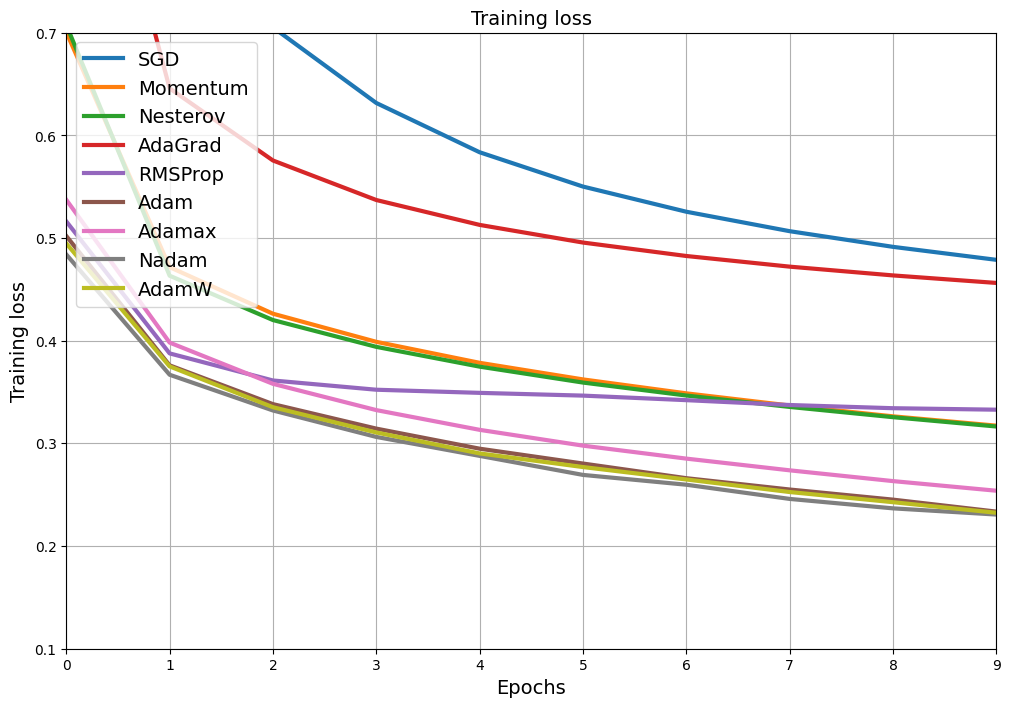

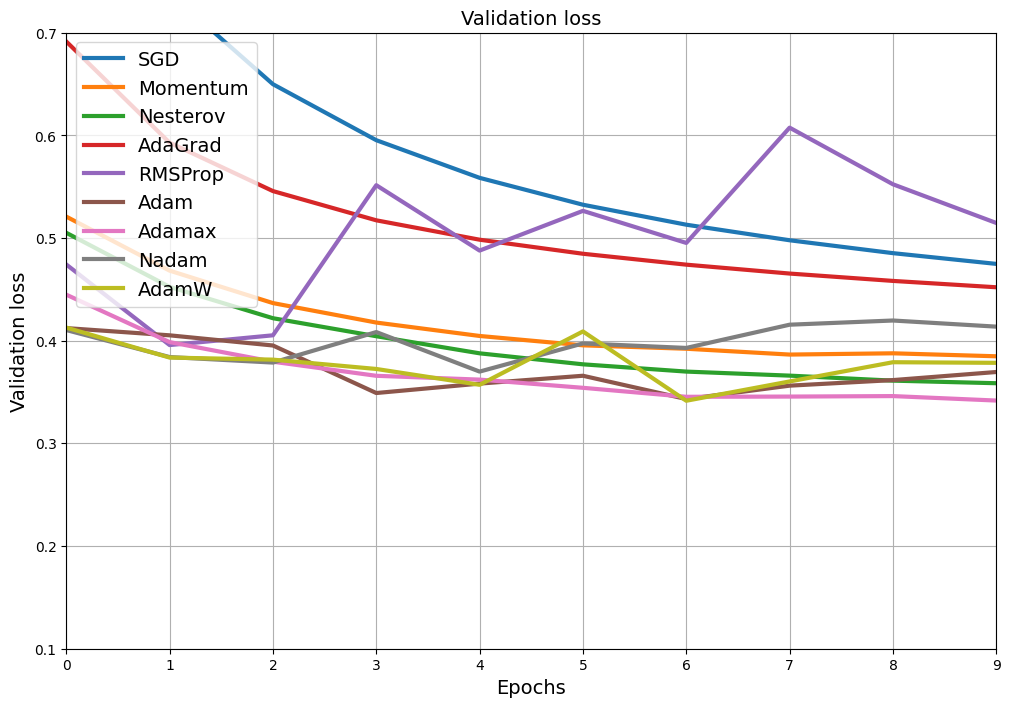

In [82]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.title({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

# Learning Rate Scheduling

Setting the learning rate too high will result in divergence during training, while setting it too low will have it reach convergence in a very long time. If we set it slightly too high, then it will make progress quickly at first, but then end up dancing around the optimum and never really settling down.

One method of finding a good learning rate is to train the model for a few hundred iterations, exponentially increasing the learning rate from very small value to a very large value, and then looking at the learning curve and picking a learning rate slightly lower than the one at which the learning curve starts shooting back up.

Another method is to start with a large learning rate, then reduce it once training stops making fast progress since we can reach a good solution faster than with the optimal constant learning rate. It can also be beneficial to start with a low learning rate, increase it, then drop it again. These are called *learning schedules*.

## Power Scheduling

Set the learning rate to a function of the iteration number $t$

$t: η(t) = η_0 / (1 + t/s)^c$ <br>
learning_rate = initial_learning_rate / (1 + step / decay_steps)**power


Keras uses c = 1.

The `InverseTimeDecay` uses `learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)`. If you set `staircase=True`, then it replaces `step / decay_step` with `floor(step / decay_step)`.

In [84]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
history_power_scheduling = build_and_train_model(optimizer)  # extra code

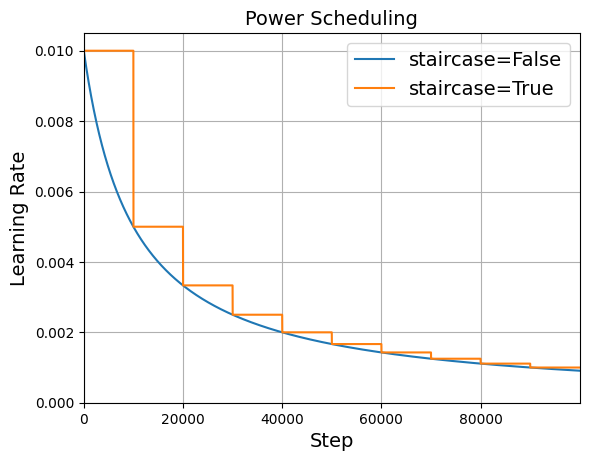

In [85]:
# extra code – this cell plots power scheduling with staircase=True or False

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## Exponential Scheduling

learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)

The learning rate will gradually drop by a factor of 10 every s decay_steps.



In [86]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [87]:
history_exponential_scheduling = build_and_train_model(optimizer)  # extra code

/Users/kevinkyhalim/ML_repo/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.6705 - loss: 0.9634 - val_accuracy: 0.8274 - val_loss: 0.4933
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - accuracy: 0.8223 - loss: 0.5002 - val_accuracy: 0.8444 - val_loss: 0.4436
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.8434 - loss: 0.4447 - val_accuracy: 0.8468 - val_loss: 0.4217
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step - accuracy: 0.8540 - loss: 0.4156 - val_accuracy: 0.8482 - val_loss: 0.4108
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - accuracy: 0.8604 - loss: 0.3968 - val_accuracy: 0.8506 - val_loss: 0.4012
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step - accuracy: 0.8645 - loss: 0.3832 - val_accuracy: 0.8544 - val_loss: 0.3926
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - accuracy: 0.8681 - loss: 0.3728 - val_accuracy: 0.8588 - val_loss: 0.3852
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step - accuracy: 0.8702 -

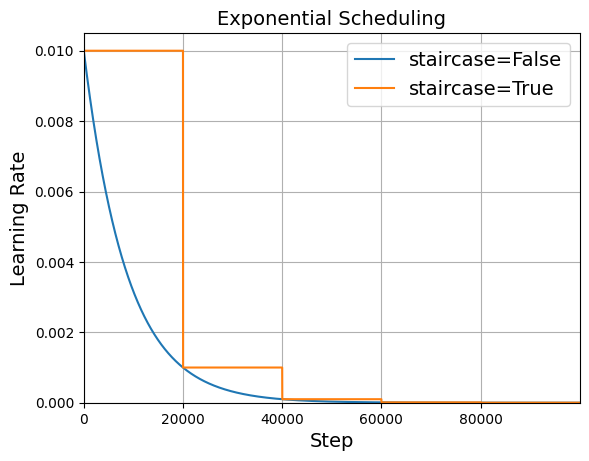

In [88]:
# extra code – this cell plots exponential scheduling

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## Piecewise constant scheduling

Use a constant learning rate for a number of epochs, then a smaller leraning rate for another number of epochs, and so on. Although this solution works well, it requires fiddling around to figure out the right sequence of learning rate and how long to use each of them.

In [89]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [90]:
history_piecewise_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6837 - loss: 0.9491 - val_accuracy: 0.8306 - val_loss: 0.4854
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 0.8283 - loss: 0.4915 - val_accuracy: 0.8374 - val_loss: 0.4466
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - accuracy: 0.8470 - loss: 0.4355 - val_accuracy: 0.8422 - val_loss: 0.4303
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.8578 - loss: 0.4035 - val_accuracy: 0.8490 - val_loss: 0.4185
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - accuracy: 0.8660 - loss: 0.3808 - val_accuracy: 0.8510 - val_loss: 0.4080
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - accuracy: 0.8705 - loss: 0.3633 - val_accuracy: 0.8556 - val_loss: 0.4018
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - accuracy: 0.8743 - loss: 0.3486 - val_accuracy: 0.8612 - val_loss: 0.3930
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - accuracy: 0.8779 -

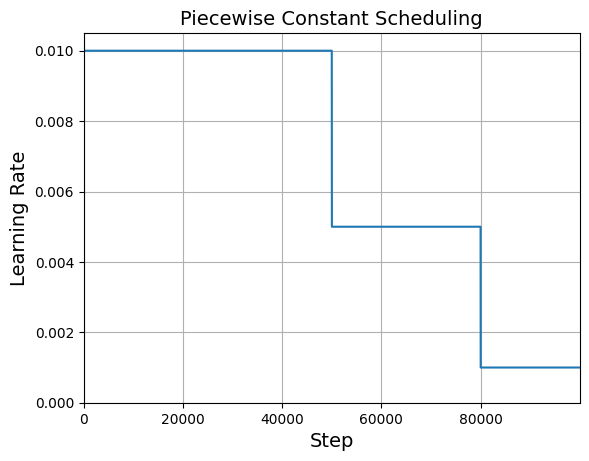

In [91]:
# extra code – this cell plots piecewise constant scheduling

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

A full list of all schedules can be seen below (under `tf.keras.optimizers.schedules`)

In [92]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay – A `LearningRateSchedule` that uses a cosine decay with optional warmup.
• CosineDecayRestarts – A `LearningRateSchedule` that uses a cosine decay schedule with restarts.
• ExponentialDecay – A `LearningRateSchedule` that uses an exponential decay schedule.
• InverseTimeDecay – A `LearningRateSchedule` that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A `LearningRateSchedule` that uses a piecewise constant decay schedule.
• PolynomialDecay – A `LearningRateSchedule` that uses a polynomial decay schedule.


## Performance Scheduling

Measures the validation error every N steps (just like for early stopping), and reduce the learning rate by a factor of of λ when the error stops dropping.

In [94]:
# extra code – build and compile the model

model = build_model()
lr0 = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [96]:
n_epochs = 20
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - accuracy: 0.6791 - loss: 0.9562 - val_accuracy: 0.8276 - val_loss: 0.4897 - learning_rate: 0.0100
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - accuracy: 0.8291 - loss: 0.4925 - val_accuracy: 0.8402 - val_loss: 0.4426 - learning_rate: 0.0100
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.8472 - loss: 0.4391 - val_accuracy: 0.8460 - val_loss: 0.4239 - learning_rate: 0.0100
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - accuracy: 0.8574 - loss: 0.4077 - val_accuracy: 0.8524 - val_loss: 0.4075 - learning_rate: 0.0100
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.8640 - loss: 0.3858 - val_accuracy: 0.8552 - val_loss: 0.3963 - learning_rate: 0.0100
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - accuracy: 0.8682 - loss: 0.3689 - val_accuracy: 0.8568 - val_loss: 0.3857 - learning_rate: 0.0100
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - accura

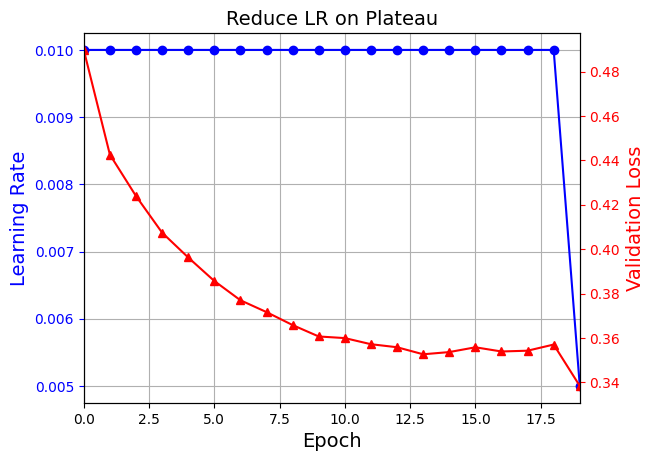

In [97]:
# extra code – this cell plots performance scheduling

plt.plot(history.epoch, history.history["learning_rate"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

## 1Cycle Scheduling

Starts with growing the initial learning rate to a certain learning rate halfway through training. Then decrease (linearly) it down to the initial learning rate during the second half of the training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The maximum learning rate is chosen using the same approach used to find the optimal learning rate, and the initial learning rate is usually 10 times lower. When using momentum, we start with a high momentum first, then drop it down to a lower momentum during the first half of training, then bringing it back up to the maximum during the second half of training, finishing the last few epochs with that maximum value.

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [98]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        lr = self.model.optimizer.learning_rate.numpy()
        self.rates.append(lr)
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = lr * self.factor

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [99]:
import math 
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [100]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

In [101]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

/Users/kevinkyhalim/ML_repo/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.2257 - loss: 2.0754


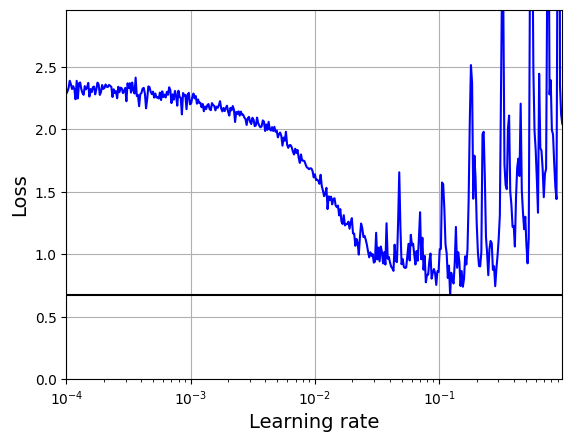

In [102]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [103]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

In [104]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5793 - loss: 1.3043 - val_accuracy: 0.7884 - val_loss: 0.6016
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.7889 - loss: 0.6058 - val_accuracy: 0.8218 - val_loss: 0.5041
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8190 - loss: 0.5175 - val_accuracy: 0.8258 - val_loss: 0.4831
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8344 - loss: 0.4720 - val_accuracy: 0.8260 - val_loss: 0.4706
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8454 - loss: 0.4380 - val_accuracy: 0.8288 - val_loss: 0.4648
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.8529 - loss: 0.4114 - val_accuracy: 0.8250 - val_loss: 0.4782
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8588 - loss: 0.3897 - val_accuracy: 0.8300 - val_loss: 0.4670
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.8648 - loss: 0.3723 - val_accura

 In general the performance and exponential scheduling performed well and favored exponential because it was easy to tune and converged slightly faster to the optimal solution. It was also mentioned that it was easier to implement than performance scheduling. That said, the 1cycle approach seems to perform even better.

# Avoiding Overfitting Through Regularization

## $l1$ and $l2$ Regularization

In [105]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [107]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [108]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [109]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 914us/step - accuracy: 0.7061 - loss: 4.0716 - val_accuracy: 0.8210 - val_loss: 1.8618
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.8139 - loss: 1.6264 - val_accuracy: 0.8226 - val_loss: 1.1198


$l_2$ is fine when using SGD, momentum optimization and Nesterov momentum optimization, but not with Adam and its variants. For Adam, use it with weight decay (AdamW)

## Dropout

At every training step, every neuron (including input but not output) has a probability $p$ (*dropout rate*) of being temporarily "dropped out" (entirely ignored during the training step), but may be active during the next step. The *dropout rate* is tupically set between 10% - 50% (closer to 20-30 for RNN and 40-50 for CNN). After training, neurons don't get dropped anymore. [In practice, you can usually apply dropout only to the neurons in the top one to three layers].

Under dropout, we need to divide the connection weights by the *keep probability* (1-p) during training since after training, a neuron would be connected to 1/ (1-p) as many input neurons as it would be during training. So we compensate thisby multiplying each neuron's input connection weights by 1/(1-p) during training.

Increase the dropout rate when the model is overfitting. It can also help to increase the dropout rate for large layers, and reduce it for small ones. Moreover, many state-of-the-art architectures only use dropout after the last hidden layer.

In general, while it is slower in converging to a solution, it often results in a better model when tuned properly.

In [110]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [111]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [112]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6766 - loss: 0.8867 - val_accuracy: 0.8340 - val_loss: 0.4353
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8071 - loss: 0.5301 - val_accuracy: 0.8340 - val_loss: 0.4344
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8229 - loss: 0.4854 - val_accuracy: 0.8544 - val_loss: 0.3971
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8329 - loss: 0.4591 - val_accuracy: 0.8556 - val_loss: 0.3813
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8329 - loss: 0.4431 - val_accuracy: 0.8552 - val_loss: 0.3788
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8386 - loss: 0.4349 - val_accuracy: 0.8624 - val_loss: 0.3634
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step - accuracy: 0.8403 - loss: 0.4232 - val_accuracy: 0.8596 - val_loss: 0.3700
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 927us/step - accuracy: 0.8478 - loss: 0.411

Note that the training accuracy is lower because dropout is only active during training.

In [113]:
model.evaluate(X_train, y_train)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - accuracy: 0.8848 - loss: 0.3105


[0.31235095858573914, 0.8837636113166809]

In [114]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.8647 - loss: 0.3653


[0.371670126914978, 0.8614000082015991]

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## Monte Carlo (MC) Dropout

Basically using dropout technique but we average over multiple predictions to give a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout turned off.


In [115]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [116]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [117]:
model.predict(X_test[:1]).round(3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.048, 0.   , 0.101, 0.   ,
        0.851]], dtype=float32)

In [118]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.072, 0.   , 0.127, 0.   ,
       0.801], dtype=float32)

In [119]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.088, 0.   , 0.127, 0.   ,
       0.142], dtype=float32)

In [120]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

np.float64(0.8605)

Replace the `Dropout` layers with the following `MCDropout` class if the model contains other layers that behave in a special way during training (e.g.`BatchNormalization`).

In [121]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [122]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [123]:
mc_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_24 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout (MCDropout)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout_1 (MCDropout)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout_2 (MCDropout)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.18, 0.  , 0.7 ]],
      dtype=float32)

## Max-Norm Regularization

For each neuron, constrain the weights **w** of the incoming connections such that $∥ w ∥_2$ ≤ r, where r is the max-norm hyperparameter and $∥ · ∥_2$ is the $l_2$ norm.

This does not add a regularization loss term to the overall loss function, and instead typicall implemented by computing $∥ w ∥_2$ after each training step and rescaling **w** if needed.

Reducing $r$ increases the amount of regularization and helps reduce overfitting.

In [125]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [126]:
# extra code – shows how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7405 - loss: 0.7367 - val_accuracy: 0.8288 - val_loss: 0.4463
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 882us/step - accuracy: 0.8456 - loss: 0.4254 - val_accuracy: 0.8298 - val_loss: 0.4316
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 903us/step - accuracy: 0.8574 - loss: 0.3865 - val_accuracy: 0.8454 - val_loss: 0.4044
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 884us/step - accuracy: 0.8661 - loss: 0.3634 - val_accuracy: 0.8446 - val_loss: 0.4023
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8695 - loss: 0.3506 - val_accuracy: 0.8398 - val_loss: 0.4048
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.8742 - loss: 0.3407 - val_accuracy: 0.8430 - val_loss: 0.3963
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.8746 - loss: 0.3344 - val_accuracy: 0.8364 - val_loss: 0.4040
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - accuracy: 0.8779 - los

After each training iteration, the model's fit() method will call the object returned by max_norm(), passing it the layer's weights and getting rescaled weights in return, which then replace the layer's weights. A custom constraint function and bias terms can be done using other arguments (e.g. `kernel_constraing` and `bias_constraint`).

The max_norm() function has an axis argument defaulting to 0. Since a `Dense` layer usually has weights of shape [# of inputs, # of neurons], axis = 0 means that the max norm constraing will apply independently to each neuron's weight vector.

# Summary and Practical Guidelines

The following configuration works fine in most cases without requiring too much hyperparameter tuning!

| Hyperparameter          | Default value                          |
|-------------------------|----------------------------------------|
| Kernel initializer      | He initialization                     |
| Activation function     | ReLU if shallow; Swish if deep         |
| Normalization           | None if shallow; batch norm if deep    |
| Regularization          | Early stopping; weight decay if needed |
| Optimizer               | Nesterov accelerated gradients or AdamW|
| Learning rate schedule  | Performance scheduling or 1cycle       |

If the network is a simple stack of dense layers and can self-normalize (don't forget to normalize the input features!).

| Hyperparameter          | Default value                          |
|-------------------------|----------------------------------------|
| Kernel initializer      | LeCun initialization                   |
| Activation function     | SELU                                   |
| Normalization           | None (self-normalization)              |
| Regularization          | Alpha dropout if needed                |
| Optimizer               | Nesterov accelerated gradients         |
| Learning rate schedule  | Performance scheduling or 1cycle       |

- For low-latency models, use fewer layers and fast activation function such as ReLU or leaky ReLU and fold the batch normalization layers into the previous layers after training. Having a sparse model will also help. Finally reduce the float precision from 32 bits to 16 or even 8 bits.

- For risk-sensitive application / inference latency is not important, use MCdropout to boost performance and get more reliable probability esimates along with uncertainty estimates!